In [3]:
#!pip install --upgrade numpy==1.22
#!pip install --upgrade tensorflow

In [5]:
import os
import sys
import pathlib
import click
import yaml
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [3]:
""" trainer.py """
import tensorflow as tf
from tensorflow.keras.utils import Progbar
import tensorflow.keras as K
from model.dataset import Dataset
from model.fp.melspec.melspectrogram import get_melspec_layer
from model.fp.specaug_chain.specaug_chain import get_specaug_chain_layer
from model.fp.nnfp import get_fingerprinter
from model.fp.NTxent_loss_single_gpu import NTxentLoss
from model.fp.online_triplet_loss import OnlineTripletLoss
from model.fp.lamb_optimizer import LAMB
from model.utils.experiment_helper import ExperimentHelper
from model.utils.mini_search_subroutines import mini_search_eval

In [4]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_specaug: spec-augmentation layer.
    m_specaug = get_specaug_chain_layer(cfg, trainable=False)
    assert(m_specaug.bypass==False) # Detachable by setting m_specaug.bypass.

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_specaug, m_fp

tr_loss = K.metrics.Mean(name='train_loss')

@tf.function
def train_step(X, m_pre, m_specaug, m_fp, loss_obj, opt):
    """ Train step """
    # X: (Xa, Xp)
    # Xa: anchors or originals, s.t. [xa_0, xa_1,...]
    # Xp: augmented replicas, s.t. [xp_0, xp_1] with xp_n = rand_aug(xa_n).
    n_anchors = len(X[0])
    X = tf.concat(X, axis=0)
    feat = m_specaug(m_pre(X))  # (nA+nP, F, T, 1)
    print(f"feat: {feat}")#Debug
    m_fp.trainable = True
    with tf.GradientTape() as t:
        #print(f"m_fp(feat): {m_fp(feat)}")#Debug
        emb = m_fp(feat)  # (BSZ, Dim)
        #print(f"emb: {emb}")#Debug
        loss, sim_mtx, _ = loss_obj.compute_loss(emb[:n_anchors, :], emb[n_anchors:, :]) # {emb_org, emb_rep}
    g = t.gradient(loss, m_fp.trainable_variables)

    opt.apply_gradients(zip(g, m_fp.trainable_variables))
    
    avg_loss = tr_loss(loss) # To tensorboard.
    
    return avg_loss, sim_mtx # avg_loss: average within the current epoch

2024-04-08 15:30:06.245220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 15:30:06.245399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 15:30:06.277719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg


def update_config(cfg, key1: str, key2: str, val):
    cfg[key1][key2] = val
    return cfg


def print_config(cfg):
    os.system("")
    print('\033[36m' + yaml.dump(cfg, indent=4, width=120, sort_keys=False) +
          '\033[0m')
    return



""" Generate fingerprint (after training) """
def generate(checkpoint_name, checkpoint_index, config, source, output, skip_dummy):
    """ Generate fingerprints from a saved checkpoint.

    ex) python run.py generate CHECKPOINT_NAME

    With custom config: \b\n
        python run.py generate CHECKPOINT_NAME -c CONFIG_NAME

    • If CHECKPOINT_INDEX is not specified, the latest checkpoint in the OUTPUT_ROOT_DIR will be loaded.
    • The default value for the fingerprinting source is [TEST_DUMMY_DB] and [TEST_QUERY_DB] specified in config file.

    """
    from model.utils.config_gpu_memory_lim import allow_gpu_memory_growth
    from model.generate import generate_fingerprint

    cfg = load_config(config)
    allow_gpu_memory_growth()
    generate_fingerprint(cfg, checkpoint_name, checkpoint_index, source, output, skip_dummy)


def evaluate(checkpoint_name, checkpoint_index, config, index_type,
             test_seq_len, test_ids, nogpu):
    """ Search and evalutation.

    ex) python run.py evaluate CHECKPOINT_NAME CHECKPOINT_INDEX

    With options: \b\n

    ex) python run.py evaluate CHECKPOINT_NAME CHEKPOINT_INDEX -i ivfpq -t 3000 --nogpu


    • Currently, the 'evaluate' command does not reference any information other
    than the output log directory from the config file.
    """
    from eval.eval_faiss import eval_faiss

    cfg = load_config(config)
    emb_dir = cfg['DIR']['OUTPUT_ROOT_DIR'] + checkpoint_name + '/' + \
        str(checkpoint_index) + '/'

    if nogpu:
        eval_faiss([emb_dir, "--index_type", index_type, "--test_seq_len",
                    test_seq_len, "--test_ids", test_ids, "--nogpu"])
    else:
        eval_faiss([emb_dir, "--index_type", index_type, "--test_seq_len",
                    test_seq_len, "--test_ids", test_ids])



In [5]:
checkpoint_name:str = "CHECKPOINT"   # string
checkpoint_index:int = None  # int
config:str = "default"       # string 'default'
index_type:str = 'IVFPQ'  # {'L2', 'IVF', 'IVFPQ', " + "'IVFPQ-RR', 'IVFPQ-ONDISK', HNSW'}"
test_seq_len:str =  '11'   # string '1 3 5 9 11 19' segundos 
test_ids:str = "icassp"      # string 'icassp'
nogpu:bool = False         # False or True
max_epoch:int = 1     # int

In [6]:
cfg = load_config(config)
dataset = Dataset(cfg)

cli: Configuration from ./config/default.yaml


In [7]:
m_pre, m_specaug, m_fp = build_fp(cfg)

In [ ]:
d = dataset.get_train_ds()

In [ ]:
d[0][1].shape

(16, 1, 8000)

In [8]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display


In [ ]:
out = d[0][0][0]

In [ ]:
out

array([[0.12594604, 0.11602783, 0.1026001 , ..., 0.03756714, 0.03939819,
        0.03936768]], dtype=float32)

In [ ]:
x1 = d[0][1][0]

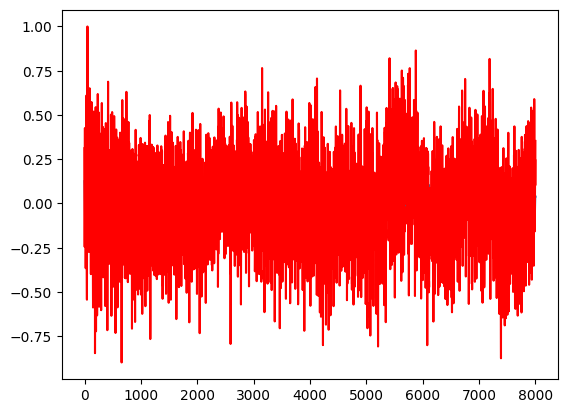

In [ ]:
plt.plot(out.squeeze())
plt.plot(x1.squeeze(),'r')
plt.show()

In [ ]:
IN = d[0]
n_anchors = len(IN[0])
n_anchors

16

In [ ]:
IN = tf.concat(IN, axis=0)

In [ ]:
IN.shape

TensorShape([32, 1, 8000])

In [ ]:
feat_IN = m_specaug(m_pre(IN))  # (nA+nP, F, T, 1)

2024-03-27 23:16:15.891969: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_1370/spec_n_cutout_21/StatefulPartitionedCall/cond/branch_executed/_104


In [ ]:
feat_IN.shape

TensorShape([32, 256, 32, 1])

In [ ]:
mel = feat_IN[0, :, :, 0].numpy()

In [ ]:
mel.shape

(256, 32)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

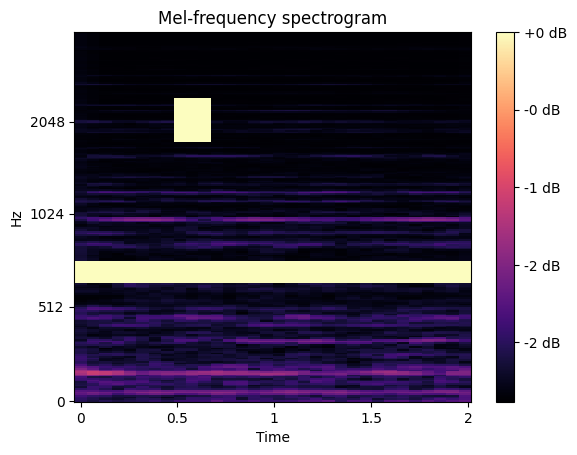

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(mel, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
mel2 = feat_IN[16, :, :, 0].numpy()

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

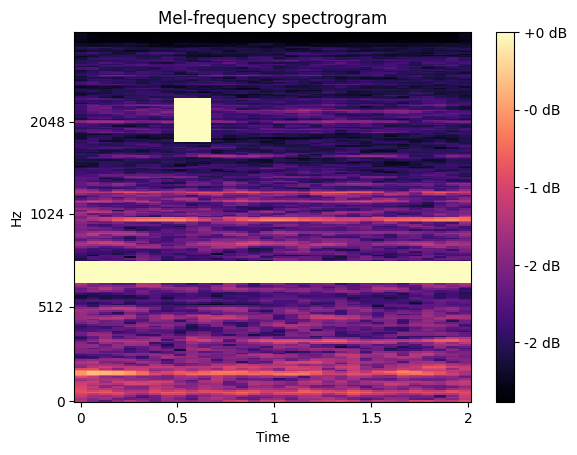

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(mel2, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
emb_IN = m_fp(feat_IN)

In [9]:
# Dataloader
dataset = Dataset(cfg)

# Build models.
m_pre, m_specaug, m_fp = build_fp(cfg)

# Learning schedule
total_nsteps = cfg['TRAIN']['MAX_EPOCH'] * len(dataset.get_train_ds())
if cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS':
    lr_schedule = tf.keras.experimental.CosineDecay(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        decay_steps=total_nsteps,
        alpha=1e-06)
elif cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS-RESTART':
    lr_schedule = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        first_decay_steps=int(total_nsteps * 0.1),
        num_periods=0.5,
        alpha=2e-06)
else:
    lr_schedule = float(cfg['TRAIN']['LR'])

# Optimizer
if cfg['TRAIN']['OPTIMIZER'].upper() == 'LAMB':
    opt = LAMB(learning_rate=lr_schedule)
elif cfg['TRAIN']['OPTIMIZER'].upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
else:
    raise NotImplementedError(cfg['TRAIN']['OPTIMIZER'])

# Loss objects
if cfg['LOSS']['LOSS_MODE'].upper() == 'NTXENT': # Default
    loss_obj_train = NTxentLoss(
        n_org=cfg['BSZ']['TR_N_ANCHOR'],
        n_rep=cfg['BSZ']['TR_BATCH_SZ'] - cfg['BSZ']['TR_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
else:
    raise NotImplementedError(cfg['LOSS']['LOSS_MODE'])


In [10]:
ep = 0

# Train
""" Parallelism to speed up preprocessing.............. """
train_ds = dataset.get_train_ds(cfg['DATA_SEL']['REDUCE_ITEMS_P'])

enq = tf.keras.utils.OrderedEnqueuer(
    train_ds, use_multiprocessing=True, shuffle=train_ds.shuffle)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'],
            max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])
i = 0
while i < len(enq.sequence):
    X = next(enq.get()) # X: Tuple(Xa, Xp)
    print(f"mini-batch {i} of {len(enq.sequence)}")

    avg_loss, sim_mtx = train_step(X, m_pre, m_specaug, m_fp, loss_obj_train, opt=opt)
    print(f"avg_loss {avg_loss}")

    i += 1
enq.stop()
""" End of Parallelism................................. """

mini-batch 0 of 36365
feat: Tensor("spec_aug_chainer_1/StatefulPartitionedCall:0", shape=(32, 256, 32, 1), dtype=float32)
feat: Tensor("spec_aug_chainer_1/StatefulPartitionedCall:0", shape=(32, 256, 32, 1), dtype=float32)


2024-04-04 16:05:29.114363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: spec_aug_chainer_1/StatefulPartitionedCall/sequential_137/spec_n_cutout_2/StatefulPartitionedCall/cond/branch_executed/_4761
I0000 00:00:1712243135.479452 2548063 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


avg_loss 6.549516677856445
mini-batch 1 of 36365
avg_loss 6.616794586181641
mini-batch 2 of 36365
avg_loss 6.593303680419922
mini-batch 3 of 36365
avg_loss 6.591316223144531
mini-batch 4 of 36365
avg_loss 6.4898223876953125
mini-batch 5 of 36365
avg_loss 6.4705491065979
mini-batch 6 of 36365
avg_loss 6.401048183441162
mini-batch 7 of 36365
avg_loss 6.388060569763184
mini-batch 8 of 36365
avg_loss 6.2729716300964355
mini-batch 9 of 36365
avg_loss 6.255603790283203
mini-batch 10 of 36365
avg_loss 6.159310817718506
mini-batch 11 of 36365
avg_loss 6.05722188949585
mini-batch 12 of 36365
avg_loss 5.950194358825684
mini-batch 13 of 36365
avg_loss 5.886758327484131
mini-batch 14 of 36365
avg_loss 5.844727993011475
mini-batch 15 of 36365
avg_loss 5.738345623016357
mini-batch 16 of 36365
avg_loss 5.637192726135254
mini-batch 17 of 36365
avg_loss 5.525661945343018
mini-batch 18 of 36365
avg_loss 5.5068135261535645
mini-batch 19 of 36365
avg_loss 5.435420036315918
mini-batch 20 of 36365
avg_loss 

' End of Parallelism................................. '

In [1]:
import tensorflow as tf

2024-03-28 15:28:29.305944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 15:28:30.004661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
tf.test.is_gpu_available()

In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
tf.config.list_physical_devices('GPU')

2024-03-27 23:05:17.923828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 23:05:17.924221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 23:05:17.924531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.15.0


In [ ]:
import torch
print(torch.__version__)

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(num_devices)

    for i in range(num_devices):
        device = torch.cuda.get_device_name(i)
        print(f"Device CUDA {i}: {device}")
else:
    print("CUDA not available.")

2
Device CUDA 0: NVIDIA GeForce RTX 3090
Device CUDA 1: NVIDIA GeForce RTX 2080 Ti


In [ ]:
import tensorrt
print(tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

In [ ]:
import tensorrt_lean as trt
print(trt.__version__)
assert trt.Runtime(trt.Logger())

In [ ]:
import tensorrt_dispatch as trt
print(trt.__version__)
assert trt.Runtime(trt.Logger())

## Compute loss - validation loss and training loss

EPOCH: 2/100
<br>36365/36365 [==============================] - 2375s 65ms/step - tr loss: 0.4658
<br>tr_loss:0.4316, val_loss:3.3138
<br>======= mini-search-validation: argmin f =======
<br>Scope: &nbsp; 1 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 9 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 11 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 19	 
<br>T1acc: &nbsp; 73.79 &nbsp; 95.15 &nbsp; 99.19 &nbsp; 100.00 &nbsp; 100.00 &nbsp; 100.00	
<br>mRank: &nbsp; 2.90 &nbsp; 0.15 &nbsp;&nbsp;&nbsp; 0.01 &nbsp;&nbsp;&nbsp; 0.00 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;	0.00 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;	0.00	
<br>======= mini-search-validation: argmin L2(f) =======
<br>Scope: &nbsp; 1 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 9 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 11 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 19 	 
<br>T1acc: &nbsp; 73.86 &nbsp;	95.15 &nbsp; 99.19 &nbsp; 100.00 &nbsp; 100.00 &nbsp;	100.00	
<br>mRank: &nbsp; 2.89 &nbsp; 0.15 &nbsp;&nbsp;&nbsp; 0.01 &nbsp;&nbsp;&nbsp; 0.00 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.00 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.00	
<br>======= mini-search-validation: argmin g(f) =======
<br>Scope: &nbsp; 1 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 9 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 11 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 19  	 
<br>T1acc &nbsp; 75.87 &nbsp; 96.30 &nbsp; 99.26 &nbsp; 100.00 &nbsp; 100.00 &nbsp; 100.00	
<br>mRank: &nbsp; 1.99 &nbsp; 0.08 &nbsp;&nbsp;&nbsp; 0.01 &nbsp;&nbsp;&nbsp; 0.00 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.00 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.00

In [17]:
train_loss = [0.7873,0.4316,0.3520,0.3069,0.2774,0.2555,0.2392,0.2246,0.2132,0.2027,0.1944,0.1884,0.1813,0.1737,0.1694,0.1647,0.1612,0.1561,0.1531,0.1500,0.1443,0.1429,0.1381,0.1371,0.1338,0.1326,0.1288,0.1272,0.1234,0.1217,0.1195,0.1181,0.1163,0.1137,0.1135,0.1115,0.1096,0.1071,0.1072,0.1035,0.1030,0.1028,0.1011,0.0994,0.0980,0.0973,0.0945,0.0947,0.0941,0.0920,0.0905,0.0891,0.0879,0.0862,0.0860,0.0855,0.0845,0.0841,0.0828,0.0817,0.0805,0.0807,0.0798,0.0783,0.0781,0.0779,0.0759,0.0745,0.0747,0.0733,0.0729,0.0733,0.0716,0.0722,0.0718,0.0703,0.0711,0.0698,0.0694,0.0696,0.0678,0.0673,0.0686,0.0674,0.0671,0.0669,0.0668,0.0672,0.0659,0.0658,0.0660,0.0658,0.0645,0.0648,0.0660,0.0661,0.0652,0.0651,0.0640,0.0655]
val_loss = [3.2719,3.3138,3.0586,3.1283,3.0887,3.1191,3.0887,2.9650,2.8631,3.0724,2.9248,3.0626,2.9176,3.0661,2.9647,2.9925,2.9446,2.9264,3.0110,2.9345,2.8536,3.0006,3.0330,2.8814,2.8888,2.8475,2.8250,2.8103,2.9309,2.8613,2.9033,2.8676,2.8616,2.8454,2.7798,2.8179,2.8668,2.8246,2.8251,2.8784,2.8772,2.9164,2.8873,2.8332,2.7925,2.8277,2.8034,2.7830,2.8026,2.8109,2.8214,2.7793,2.7854,2.7893,2.7888,2.8564,2.7757,2.7367,2.7636,2.8091,2.7758,2.8262,2.7986,2.8219,2.8025,2.8326,2.8261,2.7445,2.8155,2.8080,2.7466,2.7599,2.7841,2.7656,2.7902,2.7522,2.7549,2.7736,2.7591,2.7700,2.7744,2.7589,2.7576,2.7518,2.7923,2.7433,2.7855,2.7747,2.7274,2.7507,2.7489,2.7983,2.7506,2.7571,2.7579,2.7538,2.7802,2.7737,2.7499,2.7461] 

In [20]:
epochs = range(1, len(train_loss) + 1)

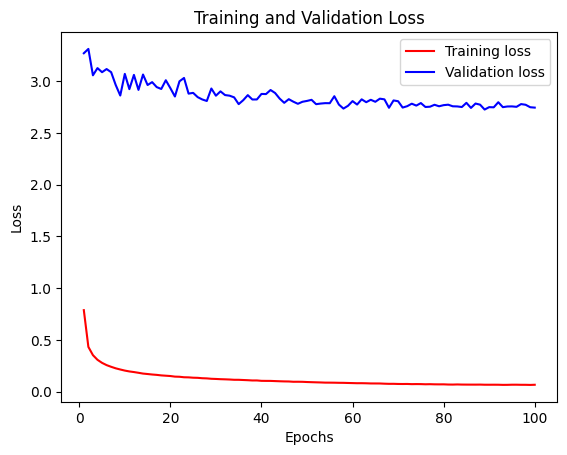

In [27]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
loss = [1.1586,0.4658,0.3671,0.3155,0.2853,0.2600,0.2409,0.2291,0.2137,0.2034,0.1949,0.1885,0.1832,0.1752,0.1695,0.1657,0.1626,0.1574,0.1544,0.1487,0.1465,0.1448,0.1369,0.1389,0.1338,0.1326,0.1281,0.1288,0.1236,0.1219,0.1192,0.1182,0.1167,0.1127,0.1140,0.1144,0.1104,0.1080,0.1090,0.1026,0.1030,0.1018,0.1008,0.0990,0.0977,0.0983,0.0945,0.0956,0.0956,0.0941,0.0929,0.0908,0.0877,0.0868,0.0859,0.0864,0.0873,0.0848,0.0836,0.0809,0.0798,0.0811,0.0807,0.0784,0.0781,0.0786,0.0754,0.0748,0.0763,0.0739,0.0738,0.0724,0.0720,0.0728,0.0720,0.0713,0.0716,0.0698,0.0709,0.0690,0.0680,0.0685,0.0701,0.0671,0.0674,0.0671,0.0669,0.0659,0.0662,0.0664,0.0661,0.0660,0.0638,0.0643,0.0666,0.0678,0.0643,0.0640,0.0637,0.0647]

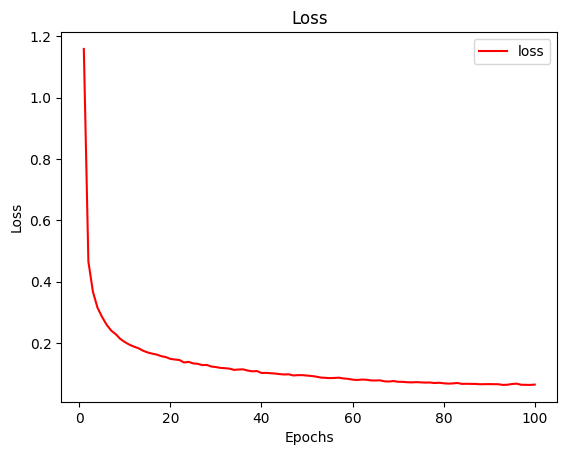

In [26]:
plt.plot(epochs, loss, 'r', label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


model = get_fingerprinter(cfg, trainable=False)

# Carregar o modelo a partir dos checkpoints
model = tf.keras.models.load_model('/home/rodrigo/Documents/neural-audio-fp/logs/checkpoint/Checks')
model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

# Definir o otimizador e a função de loss
optimizer = opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = NTxentLoss(
        n_org=cfg['BSZ']['TR_N_ANCHOR'],
        n_rep=cfg['BSZ']['TR_BATCH_SZ'] - cfg['BSZ']['TR_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])

# Compilar o modelo (pode ser necessário, dependendo de como os checkpoints foram salvos)
model.compile(optimizer=optimizer, loss=loss_fn)

# Carregar os dados de treinamento (se necessário)

# Continuar o treinamento por uma época para obter a loss
# Se você não quiser treinar mais, você pode pular esta etapa
# model.fit(x_train, y_train, epochs=1)

# Extrair a loss do modelo
train_loss = model.history.history['loss']
# Se você tiver dados de validação, também pode extrair a loss de validação
# val_loss = model.history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotar a loss
plt.plot(epochs, train_loss, 'r', label='Training loss')
# Se você tiver loss de validação, também pode plotar
# plt.plot


# **GENERATE**

In [13]:
checkpoint_name:str = "Check_test-gen"   # string
checkpoint_index:int = 10  # int
config:str = "default"       # string 'default'
source:str = '/mnt/dataset/public/Fingerprinting/neural-audio-fp-dataset/music/test-dummy-db-100k-full/'
output:str = './logs/emb/'
skip_dummy:bool = False

In [14]:
from model.utils.config_gpu_memory_lim import allow_gpu_memory_growth
from model.generate import generate_fingerprint

cfg = load_config(config)
allow_gpu_memory_growth()

cli: Configuration from ./config/default.yaml


In [ ]:
generate_fingerprint(cfg, checkpoint_name, checkpoint_index, source, output, skip_dummy)

# Search and Evaluation